In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, label_binarize, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.base import TransformerMixin


from wordcloud import WordCloud
from collections import Counter
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/alison/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alison/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# df = pd.read_csv("data.csv", encoding='latin-1')
train_df = pd.read_csv('train_1.csv', encoding='latin-1')
test_df = pd.read_csv('test_1.csv', encoding='latin-1')
# drop salary missing rows
train_df=train_df.dropna(subset='salary')
test_df=test_df.dropna(subset='salary')
print("columns:", train_df.columns)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
year_count = 0
month_count = 0
week_count = 0
day_count = 0
hour_count = 0
unit_count = 0

from_count = 0
upto_count = 0 
dash_count = 0
interval_year_idx = []
# year_dash = []
other = []

for idx, salary in enumerate(train_df['salary'], 0):
    hour = re.search(r'hour', salary)
    day = re.search(r'day', salary)
    week = re.search(r'week', salary)
    month = re.search(r'month', salary)
    year = re.search(r'year', salary)
    from_ = re.search(r'From', salary)
    upto = re.search(r'Up', salary)
    dash = re.search(r'-', salary)
    if hour:
        hour_count += 1
    elif day:
        day_count += 1
    elif week:
        week_count += 1
    elif month:
        month_count += 1
    elif year:
        year_count += 1
        if dash:
            interval_year_idx.append(idx)
            # year_dash.append(salary)
    else:
        unit_count += 1
        
    if from_:
        from_count += 1
    elif upto:
        upto_count += 1
    elif dash:
        dash_count += 1
    else:
        other.append(salary)
print('In Training Data:')
print("hour count:", hour_count)
print("day count:", day_count)
print("week count:", week_count)
print("month count:", month_count)
print("year count:", year_count)
print('other unit count:', unit_count)
print("total = ", hour_count + day_count + week_count + month_count + year_count)


print("\nfrom count:", from_count)
print("upto count:", upto_count)
print("dash count:", dash_count)

print('-'*50)

test_year_count = 0
test_month_count = 0
test_week_count = 0
test_day_count = 0
test_hour_count = 0
test_unit_count = 0

test_from_count = 0
test_upto_count = 0 
test_dash_count = 0
test_interval_year_idx = []
# year_dash = []
test_other = []

for idx, salary in enumerate(test_df['salary'], 0):
    hour = re.search(r'hour', salary)
    day = re.search(r'day', salary)
    week = re.search(r'week', salary)
    month = re.search(r'month', salary)
    year = re.search(r'year', salary)
    from_ = re.search(r'From', salary)
    upto = re.search(r'Up', salary)
    dash = re.search(r'-', salary)
    if hour:
        test_hour_count += 1
    elif day:
        test_day_count += 1
    elif week:
        test_week_count += 1
    elif month:
        test_month_count += 1
    elif year:
        test_year_count += 1
        if dash:
            test_interval_year_idx.append(idx)
            # year_dash.append(salary)
    else:
        test_unit_count += 1
        
    if from_:
        test_from_count += 1
    elif upto:
        test_upto_count += 1
    elif dash:
        test_dash_count += 1
    else:
        test_other.append(salary)
print('In Testing Data:')
print("hour count:", test_hour_count)
print("day count:", test_day_count)
print("week count:", test_week_count)
print("month count:", test_month_count)
print("year count:", test_year_count)
print('other unit count:', test_unit_count)
print("total = ", test_hour_count + test_day_count + test_week_count + test_month_count + test_year_count)


print("\nfrom count:", test_from_count)
print("upto count:", test_upto_count)
print("dash count:", test_dash_count)

columns: Index(['title', 'company', 'salary', 'rating', 'review_count', 'types',
       'location', 'relative_time', 'hires_needed', 'hires_needed_exact',
       'urgently_hiring', 'remote_work_model', 'snippet', 'dradis_job', 'link',
       'new_job', 'job_link', 'sponsored', 'featured_employer',
       'indeed_applyable', 'ad_id', 'remote_location', 'source_id',
       'hiring_event_job', 'indeed_apply_enabled', 'job_location_postal',
       'company_overview_link', 'activity_date', 'location_extras'],
      dtype='object')
In Training Data:
hour count: 0
day count: 0
week count: 0
month count: 0
year count: 10642
other unit count: 0
total =  10642

from count: 0
upto count: 0
dash count: 10642
--------------------------------------------------
In Testing Data:
hour count: 0
day count: 0
week count: 0
month count: 0
year count: 1182
other unit count: 0
total =  1182

from count: 0
upto count: 0
dash count: 1182


In [3]:
# drop the salary whose format is not interval and yearly
train_df = train_df[train_df.index.isin(interval_year_idx)]
train_df = train_df.reset_index(drop=True)
print('Training Dataset')
print(train_df.info())

Training Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10642 entries, 0 to 10641
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  10642 non-null  object 
 1   company                10642 non-null  object 
 2   salary                 10642 non-null  object 
 3   rating                 10642 non-null  float64
 4   review_count           10642 non-null  int64  
 5   types                  9383 non-null   object 
 6   location               10642 non-null  object 
 7   relative_time          10642 non-null  object 
 8   hires_needed           4594 non-null   object 
 9   hires_needed_exact     7310 non-null   object 
 10  urgently_hiring        10642 non-null  bool   
 11  remote_work_model      6109 non-null   object 
 12  snippet                10642 non-null  object 
 13  dradis_job             10642 non-null  bool   
 14  link                   10642 non-null

### EDA

In [4]:
train_df['salary_min'] = train_df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[0].replace(',', '', regex=True).astype(float)
train_df['salary_max'] = train_df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[1].replace(',', '', regex=True).astype(float)
# df['salary_unit'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[2]

train_df['average_salary'] = (train_df['salary_min'] + train_df['salary_max']) / 2

# Calculate the ratio M/m
train_df['salary_ratio'] = train_df['salary_max'] / train_df['salary_min']

# Classify into Low, Medium, or High based on the specified criteria
train_df['salary_range'] = pd.cut(train_df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed


# Print the count of each salary range
print('Training Data:')
print(train_df['salary_range'].value_counts())
print('-'*50)

test_df['salary_min'] = test_df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[0].replace(',', '', regex=True).astype(float)
test_df['salary_max'] = test_df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[1].replace(',', '', regex=True).astype(float)
# df['salary_unit'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[2]

test_df['average_salary'] = (test_df['salary_min'] + test_df['salary_max']) / 2

# Calculate the ratio M/m
test_df['salary_ratio'] = test_df['salary_max'] / test_df['salary_min']

# Classify into Low, Medium, or High based on the specified criteria
test_df['salary_range'] = pd.cut(test_df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed

test_df = test_df.dropna(subset = 'salary_range')
# df.dropna(subset = ['column1', 'column2', 'column3'], inplace=True)
# Print the count of each salary range
print('Testing Data:')
print(test_df['salary_range'].value_counts())

Training Data:
Medium    4818
High      3114
Low       2710
Name: salary_range, dtype: int64
--------------------------------------------------
Testing Data:
Medium    513
High      366
Low       303
Name: salary_range, dtype: int64


In [5]:
# Create new features
regression_pred = pd.read_csv('min_salary_predict_xgb.csv', encoding='latin-1')
preprocessed_salary = pd.read_csv('train_preprocess.csv', encoding='latin-1')

# For training data
train_df['snippet Total Words'] = train_df['snippet'].apply(lambda x: len(x.split()))
train_df['snippet Total Chars'] = train_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))
train_df['Original snippet'] = train_df['snippet']  # Save a copy of the original text for comparison

train_df['title Total Words'] = train_df['title'].apply(lambda x: len(x.split()))
train_df['title Total Chars'] = train_df['title'].apply(lambda x: sum(len(word) for word in x.split()))
train_df['Original title'] = train_df['title']  # Save a copy of the original text for comparison
train_df['min_salary_prediction'] = preprocessed_salary['salary'] 
# For testing data

test_df['snippet Total Words'] = test_df['snippet'].apply(lambda x: len(x.split()))
test_df['snippet Total Chars'] = test_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))
test_df['Original snippet'] = test_df['snippet']  # Save a copy of the original text for comparison

test_df['title Total Words'] = test_df['title'].apply(lambda x: len(x.split()))
test_df['title Total Chars'] = test_df['title'].apply(lambda x: sum(len(word) for word in x.split()))
test_df['Original title'] = test_df['title']  # Save a copy of the original text for comparison
train_df['min_salary_prediction'] = regression_pred['min_salary_prediction'] # Regression output to predict the lower bound of salary 

In [6]:
# Identify categorical columns
boolean_features = ['urgently_hiring', 'dradis_job', 'new_job', 'sponsored', 'featured_employer',
                    'indeed_applyable', 'remote_location', 'hiring_event_job']

categorical_features = ['types', 'remote_work_model', 'hires_needed_exact', 'company', 'location', 'salary_range']

numerical_features = ['rating', 'review_count', 'salary_range', 'min_salary_prediction']

text_features = ['snippet', 'title']



<Figure size 864x576 with 0 Axes>

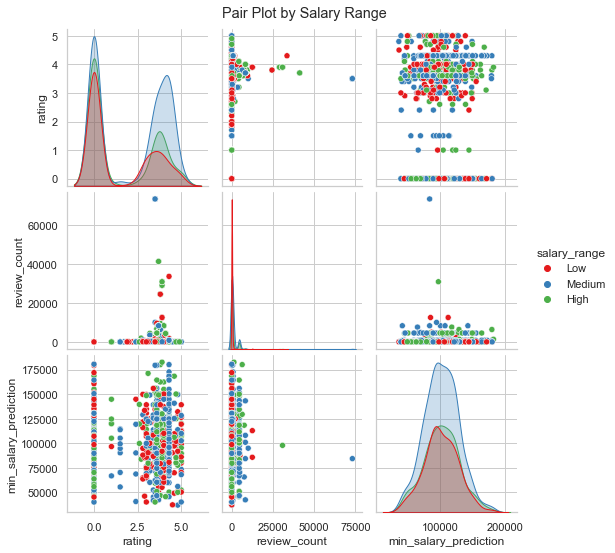

In [7]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
g = sns.pairplot(data=train_df[numerical_features], hue='salary_range', palette='Set1')
g.fig.suptitle("Pair Plot by Salary Range", y=1.02)

plt.show()

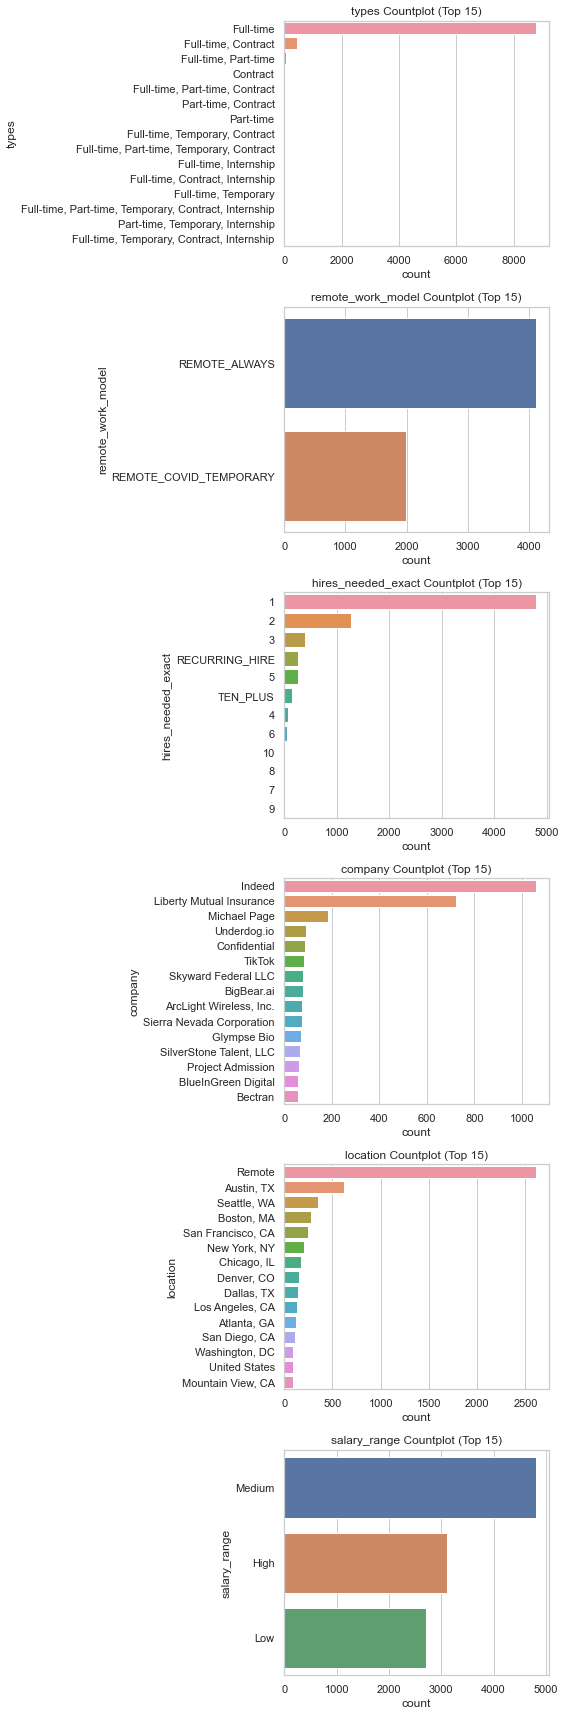

In [8]:
# Set the top N classes to display
top_n = 15

# Set up subplots
fig, axes = plt.subplots(nrows=len(categorical_features), figsize=(8, 4 * len(categorical_features)))

# Plot countplots for each categorical feature
for i, feature in enumerate(categorical_features):
    # Select the top N classes based on frequency
    top_classes = train_df[feature].value_counts().nlargest(top_n).index
    sns.countplot(y=feature, data=train_df[train_df[feature].isin(top_classes)], ax=axes[i], order=top_classes)
    axes[i].set_title(f'{feature} Countplot (Top {top_n})')

plt.tight_layout()
plt.show()


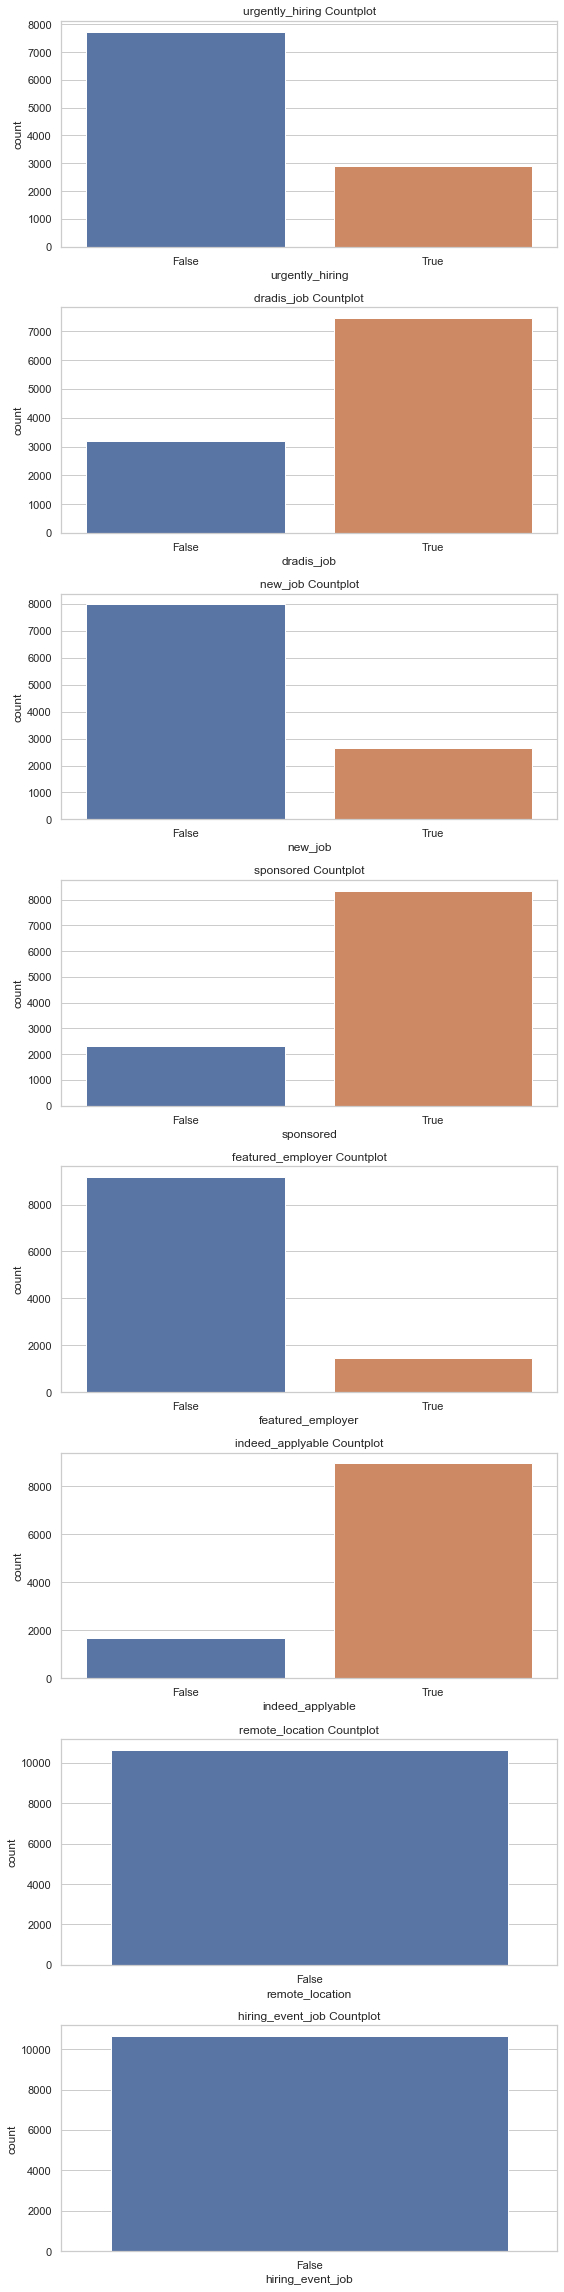

In [9]:
# print(train_df.columns)
# Set up subplots
fig, axes = plt.subplots(nrows=len(boolean_features), figsize=(8, 4 * len(boolean_features)))

# Plot countplots for each categorical feature
for i, feature in enumerate(boolean_features):
    # Select the top N classes based on frequency
    if feature in train_df.columns: # Some boolean features may even don't exist after splitting
        sns.countplot(x=feature, data=train_df, ax=axes[i])
        axes[i].set_title(f'{feature} Countplot')

plt.tight_layout()
plt.show()

### Feature Selection

In [10]:
train_df.drop(['link', 'company_overview_link', 'job_link'], axis=1, inplace=True) # drop link
train_df.drop(['ad_id', 'source_id', 'job_location_postal'], axis=1, inplace=True) # drop meaningless values for salary
train_df.drop('indeed_apply_enabled', axis=1, inplace=True) # drop correlation=1 features
train_df.drop(['hiring_event_job', 'remote_location'], axis=1, inplace=True) # drop all same class features
train_df.drop(['location_extras', 'relative_time', 'hires_needed', 'activity_date'], axis=1, inplace=True) # drop preprocessed data
train_df.columns

Index(['title', 'company', 'salary', 'rating', 'review_count', 'types',
       'location', 'hires_needed_exact', 'urgently_hiring',
       'remote_work_model', 'snippet', 'dradis_job', 'new_job', 'sponsored',
       'featured_employer', 'indeed_applyable', 'salary_min', 'salary_max',
       'average_salary', 'salary_ratio', 'salary_range', 'snippet Total Words',
       'snippet Total Chars', 'Original snippet', 'title Total Words',
       'title Total Chars', 'Original title', 'min_salary_prediction'],
      dtype='object')

missing value count:
title                       0
company                     0
salary                      0
rating                      0
review_count                0
types                    1259
location                    0
hires_needed_exact       3332
urgently_hiring             0
remote_work_model        4533
snippet                     0
dradis_job                  0
new_job                     0
sponsored                   0
featured_employer           0
indeed_applyable            0
salary_min                  0
salary_max                  0
average_salary              0
salary_ratio                0
salary_range                0
snippet Total Words         0
snippet Total Chars         0
Original snippet            0
title Total Words           0
title Total Chars           0
Original title              0
min_salary_prediction    9460
dtype: int64


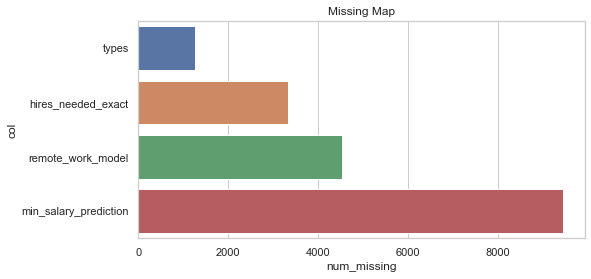

In [11]:
miss_cnt = train_df.isnull().sum()
print("missing value count:")
print(miss_cnt)
missing = miss_cnt[miss_cnt > 0]
if missing.empty:
    print("There are no missing values")
else:
    # print missing map
    missing.sort_values(inplace=True)
    missing_df = pd.DataFrame({'col': missing.index, 'num_missing': missing.values})

    plt.figure(figsize=(8,4))
    plt.title('Missing Map')
    sns.barplot(y='col', x='num_missing', data=missing_df)
    plt.show()

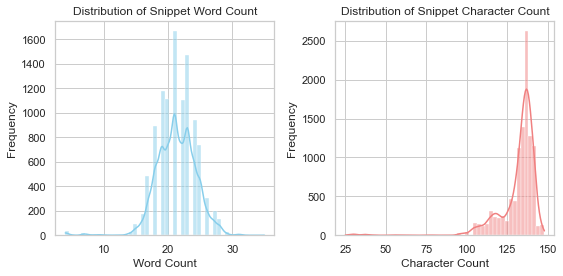

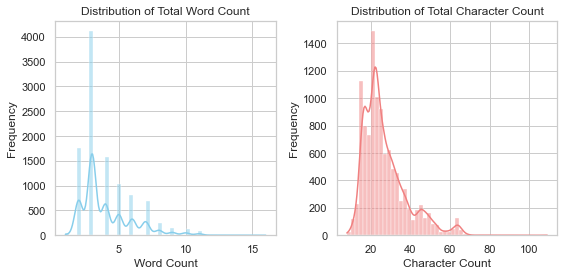

In [12]:
plt.figure(figsize=(8, 4))
# Plot histogram for the number of words
plt.subplot(1, 2, 1)
sns.histplot(x='snippet Total Words', data=train_df, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Snippet Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot histogram for the number of characters
plt.subplot(1, 2, 2)
sns.histplot(train_df['snippet Total Chars'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Snippet Character Count')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
# Plot histogram for the number of words
plt.subplot(1, 2, 1)
sns.histplot(x='title Total Words', data=train_df, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Total Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot histogram for the number of characters
plt.subplot(1, 2, 2)
sns.histplot(train_df['title Total Chars'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Total Character Count')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



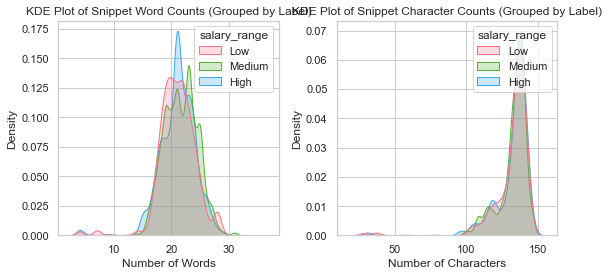

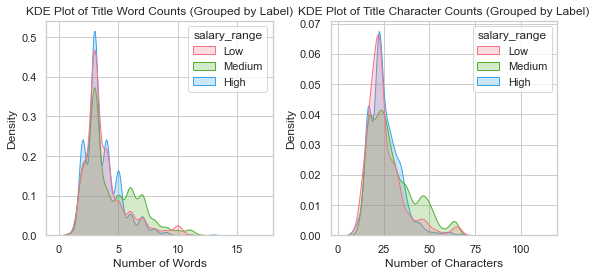

In [13]:
# Plotting KDEs and boxplots
plt.figure(figsize=(8, 4))
# KDE plot for the number of words grouped by 'label'
plt.subplot(1, 2, 1)
sns.kdeplot(x='snippet Total Words', data=train_df, hue='salary_range', common_norm=False, fill=True, palette='husl')
plt.title('KDE Plot of Snippet Word Counts (Grouped by Label)')
plt.xlabel('Number of Words')
plt.ylabel('Density')

# KDE plot for the number of characters grouped by 'label'
plt.subplot(1, 2, 2)
sns.kdeplot(x='snippet Total Chars', data=train_df, hue='salary_range', common_norm=False, fill=True, palette='husl')
plt.title('KDE Plot of Snippet Character Counts (Grouped by Label)')
plt.xlabel('Number of Characters')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


# Plotting KDEs and boxplots
plt.figure(figsize=(8, 4))
# KDE plot for the number of words grouped by 'label'
plt.subplot(1, 2, 1)
sns.kdeplot(x='title Total Words', data=train_df, hue='salary_range', common_norm=False, fill=True, palette='husl')
plt.title('KDE Plot of Title Word Counts (Grouped by Label)')
plt.xlabel('Number of Words')
plt.ylabel('Density')

# KDE plot for the number of characters grouped by 'label'
plt.subplot(1, 2, 2)
sns.kdeplot(x='title Total Chars', data=train_df, hue='salary_range', common_norm=False, fill=True, palette='husl')
plt.title('KDE Plot of Title Character Counts (Grouped by Label)')
plt.xlabel('Number of Characters')
plt.ylabel('Density')

plt.tight_layout()


### Text Preprocessing

In [14]:
train_df['snippet'] = train_df['Original snippet']
train_df['title'] = train_df['Original title']

test_df['snippet'] = test_df['Original snippet']
test_df['title'] = test_df['Original title']

# Initialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

# Function to track removed characters and words
def track_changes(original_text, processed_text, step_name):
    removed_chars = len(original_text) - len(processed_text)
    removed_words = len(original_text.split()) - len(processed_text.split())
    removal_counters[step_name]['characters'] += removed_chars
    removal_counters[step_name]['words'] += removed_words
    return processed_text


# Removing URLs
def remove_url(text):
    re_url = re.compile(r'(http\S+|www\.\S+)')
    processed_text = re_url.sub('', text)
    return track_changes(text, processed_text, 'Removing URLs')


# Removing Punctuations
exclude = string.punctuation

def remove_punc(text):
    # Combine words that should stay together
    combined_text = re.sub(r'\b(?:not|should stay together|inner-city|political-correct)\b', lambda match: match.group().replace(' ', '_'), text)
    # Remove punctuations excluding numbers and ASCII characters that did not translate
    processed_text = re.sub(r'[^\w\s]|_', '', combined_text)
    return track_changes(text, processed_text, 'Removing Punctuations')


# Removing Stopwords
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = set(stopwords.words('english'))
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    processed_text = ' '.join(new_list)
    return track_changes(text, processed_text, 'Removing Stopwords')


# Removing Numbers
def remove_numbers(text):
    processed_text = re.sub(r'\b\d+\b', '', text)
    return track_changes(text, processed_text, 'Removing Numbers')


# Removing ASCII characters that cannot translate
def remove_non_translatable_ascii(text):
    processed_text = ''.join(char for char in text if char.isascii() and not char.isdigit())
    return track_changes(text, processed_text, 'Removing ASCII that cannot translate')


# Removing unnecessary whitespace
def remove_unnecessary_whitespace(text):
    processed_text = ' '.join(text.split())
    return track_changes(text, processed_text, 'Removing unnecessary whitespace')


# Stemming
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = [stemmer.stem(word) for word in word_tokenize(text)]
    processed_text = " ".join(new_list)
    return track_changes(text, processed_text, 'Stemming')




In [15]:
# Handle Training Data
train_df['snippet'] = train_df['snippet'].apply(lambda x: x.lower())
train_df['snippet'] = train_df['snippet'].apply(remove_url)
train_df['snippet'] = train_df['snippet'].apply(remove_punc)
train_df['snippet'] = train_df['snippet'].apply(remove_stopwords)
train_df['snippet'] = train_df['snippet'].apply(remove_numbers)
train_df['snippet'] = train_df['snippet'].apply(remove_non_translatable_ascii)
train_df['snippet'] = train_df['snippet'].apply(remove_unnecessary_whitespace)
train_df['snippet'] = train_df['snippet'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
train_df['Total Words of snippet After Transformation'] = train_df['snippet'].apply(lambda x: len(x.split()))
train_df['Total Chars of snippet After Transformation'] = train_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_train_df = pd.DataFrame(removal_counters).T
print('Training Data:')
print("Snippet Removal Counters:")
print(removal_counters_train_df)
# print(train_df[['snippet', 'Original snippet']])

# reinitialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

train_df['title'] = train_df['title'].apply(lambda x: x.lower())
train_df['title'] = train_df['title'].apply(remove_url)
train_df['title'] = train_df['title'].apply(remove_punc)
train_df['title'] = train_df['title'].apply(remove_stopwords)
train_df['title'] = train_df['title'].apply(remove_numbers)
train_df['title'] = train_df['title'].apply(remove_non_translatable_ascii)
train_df['title'] = train_df['title'].apply(remove_unnecessary_whitespace)
train_df['title'] = train_df['title'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
train_df['Total Words of title After Transformation'] = train_df['title'].apply(lambda x: len(x.split()))
train_df['Total Chars of title After Transformation'] = train_df['title'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_train_df = pd.DataFrame(removal_counters).T
print("Title Removal Counters:")
print(removal_counters_train_df)
# print(df[['title', 'Original title']])

Training Data:
Snippet Removal Counters:
                                      characters  words
Removing URLs                                533      2
Removing Punctuations                      50710    910
Removing Stopwords                        262464  67706
Removing Numbers                            4600   3209
Removing ASCII that cannot translate        1132      0
Removing unnecessary whitespace             3209      0
Stemming                                  239556      0
Title Removal Counters:
                                      characters  words
Removing URLs                                  0      0
Removing Punctuations                       9608   2325
Removing Stopwords                          5178    789
Removing Numbers                             546    267
Removing ASCII that cannot translate         657      0
Removing unnecessary whitespace              267      0
Stemming                                   52649      0


In [16]:
# Handle Testing Data
test_df['snippet'] = test_df['snippet'].apply(lambda x: x.lower())
test_df['snippet'] = test_df['snippet'].apply(remove_url)
test_df['snippet'] = test_df['snippet'].apply(remove_punc)
test_df['snippet'] = test_df['snippet'].apply(remove_stopwords)
test_df['snippet'] = test_df['snippet'].apply(remove_numbers)
test_df['snippet'] = test_df['snippet'].apply(remove_non_translatable_ascii)
test_df['snippet'] = test_df['snippet'].apply(remove_unnecessary_whitespace)
test_df['snippet'] = test_df['snippet'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
test_df['Total Words of snippet After Transformation'] = test_df['snippet'].apply(lambda x: len(x.split()))
test_df['Total Chars of snippet After Transformation'] = test_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_test_df = pd.DataFrame(removal_counters).T
print('Testing Data:')
print("Snippet Removal Counters:")
print(removal_counters_test_df)
# print(test_df[['snippet', 'Original snippet']])

# reinitialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

test_df['title'] = test_df['title'].apply(lambda x: x.lower())
test_df['title'] = test_df['title'].apply(remove_url)
test_df['title'] = test_df['title'].apply(remove_punc)
test_df['title'] = test_df['title'].apply(remove_stopwords)
test_df['title'] = test_df['title'].apply(remove_numbers)
test_df['title'] = test_df['title'].apply(remove_non_translatable_ascii)
test_df['title'] = test_df['title'].apply(remove_unnecessary_whitespace)
test_df['title'] = test_df['title'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
test_df['Total Words of title After Transformation'] = test_df['title'].apply(lambda x: len(x.split()))
test_df['Total Chars of title After Transformation'] = test_df['title'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_test_df = pd.DataFrame(removal_counters).T
print("Title Removal Counters:")
print(removal_counters_test_df)

Testing Data:
Snippet Removal Counters:
                                      characters  words
Removing URLs                                 42      0
Removing Punctuations                      15198   2436
Removing Stopwords                         34463   8345
Removing Numbers                            1005    602
Removing ASCII that cannot translate         809      1
Removing unnecessary whitespace              603      0
Stemming                                   79110      0
Title Removal Counters:
                                      characters  words
Removing URLs                                  0      0
Removing Punctuations                       1102    250
Removing Stopwords                           672    115
Removing Numbers                              70     31
Removing ASCII that cannot translate          88      0
Removing unnecessary whitespace               31      0
Stemming                                    5990      0


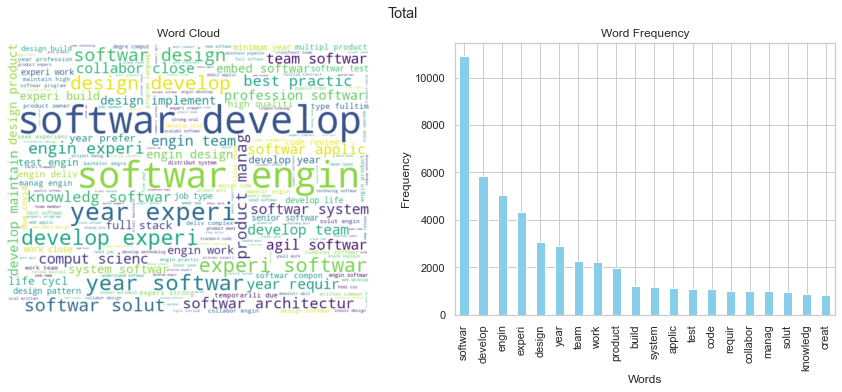

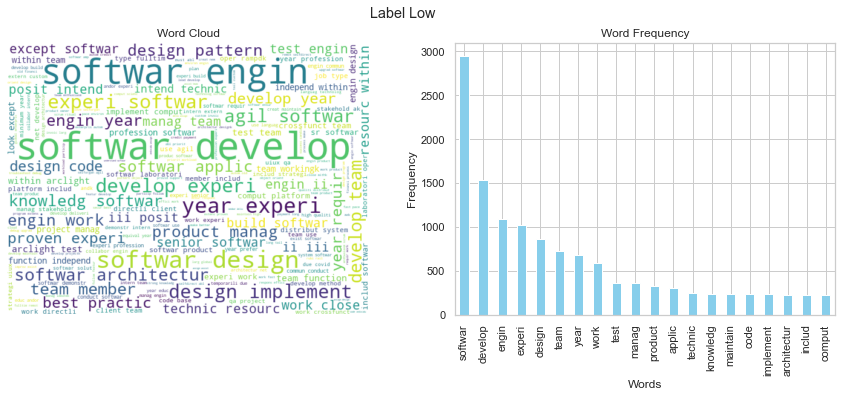

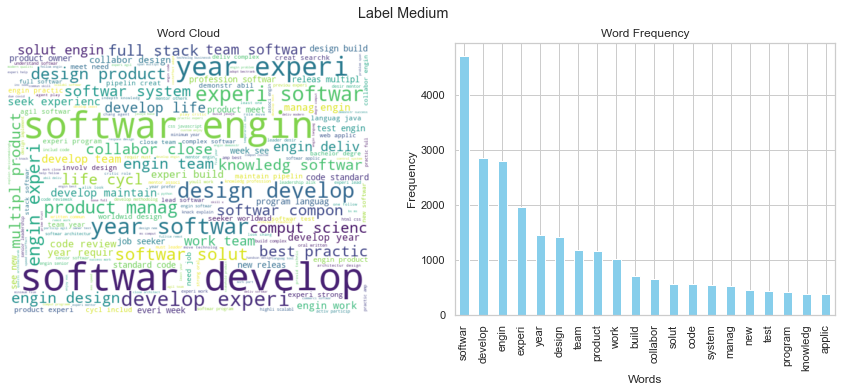

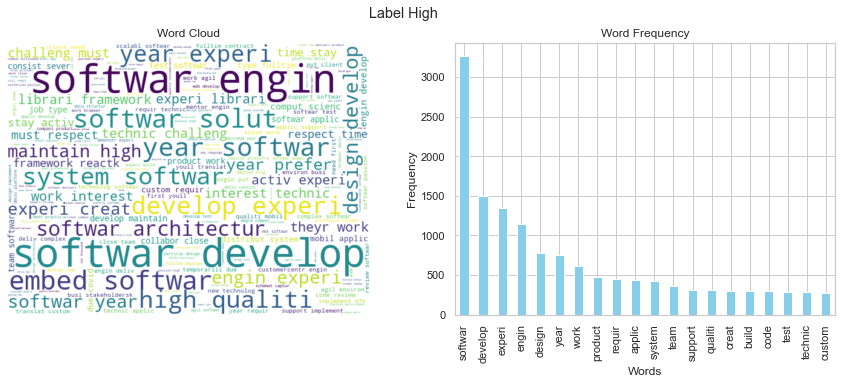

In [17]:
# Word Cloud and Word Frequency in 1 Figure
def generate_combined_plot(data, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Generate Word Cloud
    wordcloud = WordCloud(width=600, height=450, max_words=200, background_color='white').generate(data)
    axes[0].imshow(wordcloud, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Word Cloud')

    # Generate Word Frequency Bar Plot
    word_freq = pd.Series(' '.join(re.findall(r'\b\w+\b', data)).split()).value_counts().sort_values(ascending=False)[:20]
    word_freq.plot(kind='bar', color='skyblue', ax=axes[1])
    axes[1].set_title('Word Frequency')
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Frequency')

    plt.suptitle(title)
    plt.show()

# Generate combined plot for the total dataset
generate_combined_plot(' '.join(train_df['snippet']), 'Total')

# Generate combined plot for label 0
generate_combined_plot(' '.join(train_df[train_df['salary_range'] == 'Low']['snippet']), 'Label Low')

# Generate combined plot for label 1
generate_combined_plot(' '.join(train_df[train_df['salary_range'] == 'Medium']['snippet']), 'Label Medium')

# Generate combined plot for label 1
generate_combined_plot(' '.join(train_df[train_df['salary_range'] == 'High']['snippet']), 'Label High')

### Text Classification

In [18]:
# CountVectorizer

# Separate features and target variable
X_train_text = train_df['snippet']
y_train = train_df['salary_range']
X_test_text = test_df['snippet']
y_test = test_df['salary_range']
# print(y_test)
# print(test_df[['salary_ratio', 'salary_min', 'salary_max', 'salary_range']])

# Split the dataset into training and testing sets
# X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.1, random_state=42)

# Define the text preprocessing and SVM pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),  # Convert text to a matrix of token counts
    ('clf', SVC(kernel='linear'))  # Linear SVM classifier
])

# Train the text classifier
text_clf.fit(X_train_text, y_train)

# Make predictions on the test set
y_pred_text = text_clf.predict(X_test_text)
# print('-'*50)
# print(y_pred_text)

# Evaluate the performance of the text classifier
accuracy_text = accuracy_score(y_test, y_pred_text)
print(f"Text Classification Accuracy: {accuracy_text:.2f}")

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_text))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_text))

Text Classification Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.89      0.88       366
         Low       0.84      0.85      0.85       303
      Medium       0.91      0.90      0.91       513

    accuracy                           0.88      1182
   macro avg       0.88      0.88      0.88      1182
weighted avg       0.88      0.88      0.88      1182

Confusion Matrix:
[[324  22  20]
 [ 22 257  24]
 [ 23  26 464]]


SVM Cross-Validation Scores: [0.87022901 0.86024662 0.87140341 0.86956522 0.85957697]
SVM Cross-Validated Accuracy: 0.87 +/- 0.01
SVM Validation Accuracy: 0.86
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       964
           1       0.85      0.83      0.84       623
           2       0.83      0.82      0.82       542

    accuracy                           0.86      2129
   macro avg       0.86      0.85      0.85      2129
weighted avg       0.86      0.86      0.86      2129

Validation Confusion Matrix:
[[875  48  41]
 [ 56 516  51]
 [ 57  41 444]]


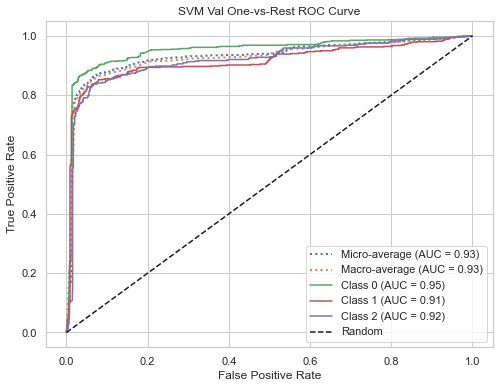

SVM Test Accuracy: 0.87
Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       513
           1       0.89      0.84      0.86       366
           2       0.82      0.84      0.83       303

    accuracy                           0.87      1182
   macro avg       0.86      0.86      0.86      1182
weighted avg       0.87      0.87      0.87      1182

Test Confusion Matrix:
[[465  22  26]
 [ 28 308  30]
 [ 31  17 255]]


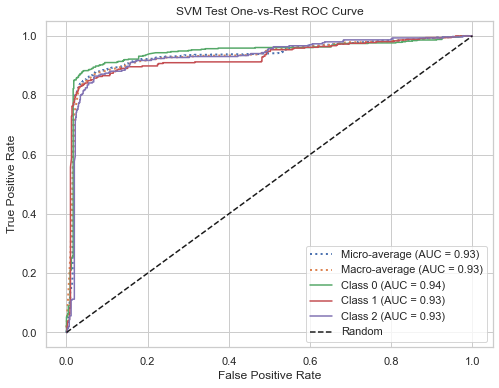

In [19]:
# Separate features and target variable
X_train = train_df['snippet']
y_train = train_df['salary_range']

X_test = test_df['snippet']
y_test = test_df['salary_range']

# Map salary range to numerical values
y_train = y_train.map({'Medium': 0, 'High': 1, 'Low': 2})
y_test = y_test.map({'Medium': 0, 'High': 1, 'Low': 2})

# Split the dataset into test (10%) and train (90%)
# X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.1, random_state=42, stratify=y)

# Further split the training set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# SVM Classifier
svm_classifier = SVC(kernel='linear', C=1)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('classifier', svm_classifier)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("SVM Cross-Validation Scores:", cv_scores)
print(f"SVM Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")


# Fit the model on the entire training set
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_val_pred = svm_classifier.predict(X_val_tfidf)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"SVM Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_val, classes=[0, 1, 2])[:, i], svm_classifier.decision_function(X_val_tfidf)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(label_binarize(y_val, classes=[0, 1, 2]).ravel(), svm_classifier.decision_function(X_val_tfidf).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
# print(f"SVM Val Micro Average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
# print(f"SVM Val Macro Average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    # print(f"SVM Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=[0, 1, 2])[:, i], svm_classifier.decision_function(X_test_tfidf)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(label_binarize(y_test, classes=[0, 1, 2]).ravel(), svm_classifier.decision_function(X_test_tfidf).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
# print(f"SVM Test Micro Average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
# print(f"SVM Test Macro Average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    # print(f"SVM Test Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()



### Classification

In [20]:
train_df.columns

Index(['title', 'company', 'salary', 'rating', 'review_count', 'types',
       'location', 'hires_needed_exact', 'urgently_hiring',
       'remote_work_model', 'snippet', 'dradis_job', 'new_job', 'sponsored',
       'featured_employer', 'indeed_applyable', 'salary_min', 'salary_max',
       'average_salary', 'salary_ratio', 'salary_range', 'snippet Total Words',
       'snippet Total Chars', 'Original snippet', 'title Total Words',
       'title Total Chars', 'Original title', 'min_salary_prediction',
       'Total Words of snippet After Transformation',
       'Total Chars of snippet After Transformation',
       'Total Words of title After Transformation',
       'Total Chars of title After Transformation'],
      dtype='object')

In [21]:


# Separate features and target variable

X_train = train_df.drop(['salary', 'salary_min', 'salary_max', 'average_salary', 'salary_ratio', 'salary_range',
             'Original snippet', 'Original title', 'snippet Total Words', 'snippet Total Chars', 'title Total Words', 'title Total Chars'], axis=1)
X_test = test_df.drop(['salary', 'salary_min', 'salary_max', 'average_salary', 'salary_ratio', 'salary_range',
             'Original snippet', 'Original title', 'snippet Total Words', 'snippet Total Chars', 'title Total Words', 'title Total Chars'], axis=1)

y_train = train_df['salary_range']
y_test = test_df['salary_range']

# Identify categorical columns
boolean_features = ['urgently_hiring', 'dradis_job', 'new_job', 'sponsored', 'featured_employer', 'indeed_applyable']

categorical_features = ['types', 'remote_work_model', 'hires_needed_exact', 'company', 'location']

numerical_features = ['rating', 'review_count', 'Total Words of snippet After Transformation', 'Total Chars of snippet After Transformation', 
                    'Total Chars of title After Transformation', 'Total Words of title After Transformation']

text_features = ['snippet', 'title']

# Define preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for boolean and categorical data
boolean_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# # Define preprocessing for text data
# text_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='')),
#     # converts the 'snippet' text data into a numerical format
#     ('tfidf', TfidfVectorizer(analyzer=lambda x: x))
#     # analyzer=lambda x: x is used to treat each element in the 'snippet' column as a single token. 
#     # This means that the vectorizer considers each entire text snippet as a single unit, rather than breaking it down into individual words.
#     # The resulting output is a sparse matrix representing the TF-IDF features of the text data.
# ])


class ArrayToStringConverter(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # for row in X:
        #     print(map(str, row))
        return [' '.join(map(str, row)) for row in X]

# Define preprocessing for text data
text_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('array_to_string', ArrayToStringConverter()),
    ('tfidf', TfidfVectorizer(analyzer='word', stop_words='english', max_features=5000))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bool_cat', boolean_categorical_transformer, boolean_features + categorical_features),
        ('text', text_transformer, text_features)
    ])

# # Encode the target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Split the dataset into test (10%) and train (90%)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Further split the training set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the target variable to binary format
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])



In [22]:
print(train_df['salary_range'].value_counts())
pd.DataFrame(y_train).value_counts()


Medium    4818
High      3114
Low       2710
Name: salary_range, dtype: int64


2    3854
0    2491
1    2168
dtype: int64

In [23]:
print('Training Columns')
X_train.columns

Training Columns


Index(['title', 'company', 'rating', 'review_count', 'types', 'location',
       'hires_needed_exact', 'urgently_hiring', 'remote_work_model', 'snippet',
       'dradis_job', 'new_job', 'sponsored', 'featured_employer',
       'indeed_applyable', 'min_salary_prediction',
       'Total Words of snippet After Transformation',
       'Total Chars of snippet After Transformation',
       'Total Words of title After Transformation',
       'Total Chars of title After Transformation'],
      dtype='object')

LogisticRegression

Logistic Regression Cross-Validation Scores: [0.89195537 0.90546095 0.90722255 0.89835488 0.88366627]
Logistic Regression Cross-Validated Accuracy: 0.90 +/- 0.01
Logistic Regression Validation Accuracy: 0.91
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       623
           1       0.86      0.89      0.88       542
           2       0.94      0.92      0.93       964

    accuracy                           0.91      2129
   macro avg       0.90      0.90      0.90      2129
weighted avg       0.91      0.91      0.91      2129

Validation Confusion Matrix:
[[556  36  31]
 [ 28 485  29]
 [ 29  45 890]]
Logistic Regression Val Micro Average AUC = 0.99
Logistic Regression Val Macro Average AUC = 0.98
Logistic Regression Val Class 0 AUC = 0.99
Logistic Regression Val Class 1 AUC = 0.98
Logistic Regression Val Class 2 AUC = 0.99


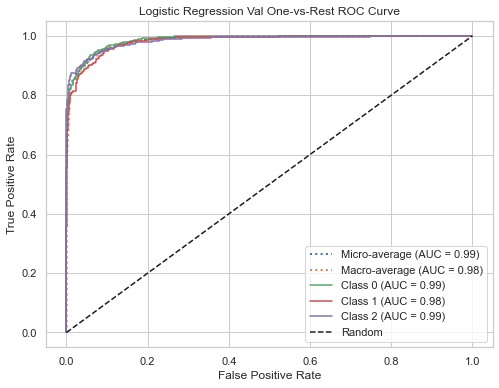

Logistic Regression Test Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       366
           1       0.86      0.91      0.89       303
           2       0.93      0.92      0.92       513

    accuracy                           0.91      1182
   macro avg       0.91      0.91      0.91      1182
weighted avg       0.91      0.91      0.91      1182

Test Confusion Matrix:
[[327  18  21]
 [ 12 276  15]
 [ 15  26 472]]
Logistic Regression Test Micro Average AUC = 0.99
Logistic Regression Test Macro Average AUC = 0.99
Logistic Regression Test Class 0 AUC = 0.99
Logistic Regression Test Class 1 AUC = 0.99
Logistic Regression Test Class 2 AUC = 0.98


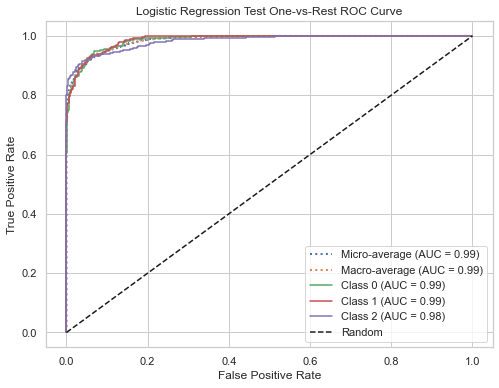

['LogisticRegression_classifier.pkl']

In [24]:
import joblib
# Define the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Logistic Regression Cross-Validation Scores:", cv_scores)
print(f"Logistic Regression Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Logistic Regression Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Val Micro Average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Val Macro Average AUC = {roc_auc_macro:.2f}")
# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Logistic Regression Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Logistic Regression Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Test Micro Average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Test Macro Average AUC = {roc_auc_micro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Logistic Regression Test Class {i} AUC = {roc_auc[i]:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()

joblib.dump(clf, 'LogisticRegression_classifier.pkl')

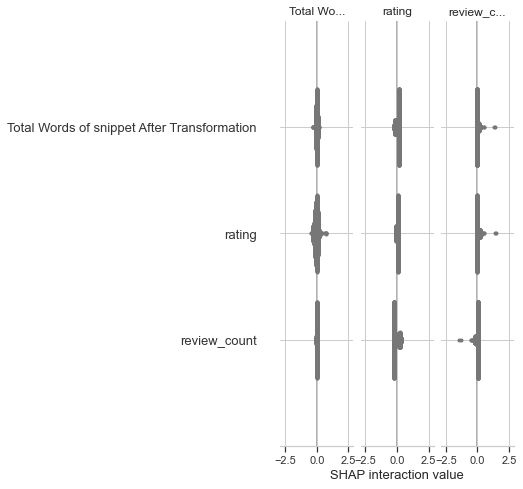

In [25]:
import shap

# We create the SHAP Explainer using the logistic regression model from the pipeline
explainer = shap.Explainer(clf.named_steps['classifier'], clf.named_steps['preprocessor'].transform(X_train))

# We calculate SHAP values for the validation set (could be the training set or test set as well)
# shap_values = explainer(clf.named_steps['preprocessor'].transform(X_val))

# # Plotting the SHAP summary plot to show feature importances
# # Note that we're not explicitly passing feature names here.
# shap.summary_plot(shap_values, feature_names=clf.named_steps['preprocessor'].get_feature_names_out())
numerical_feature_names = numerical_features

# Get feature names for boolean and categorical features from the one-hot encoder
bool_cat_feature_names = clf.named_steps['preprocessor'].named_transformers_['bool_cat'].named_steps['onehot'].get_feature_names_out(boolean_features + categorical_features)

# Get feature names for text features from the TF-IDF vectorizer
text_feature_names = clf.named_steps['preprocessor'].named_transformers_['text'].named_steps['tfidf'].get_feature_names_out()

all_feature_names = np.concatenate([numerical_feature_names, bool_cat_feature_names, text_feature_names])

# Now, use all_feature_names with SHAP
shap_values = explainer(clf.named_steps['preprocessor'].transform(X_test))
shap.summary_plot(shap_values, feature_names=all_feature_names)

SVM

SVM Cross-Validation Scores: [0.91368174 0.90487375 0.91309454 0.89306698 0.90070505]
SVM Cross-Validated Accuracy: 0.91 +/- 0.01
SVM Validation Accuracy: 0.91
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       623
           1       0.87      0.89      0.88       542
           2       0.93      0.93      0.93       964

    accuracy                           0.91      2129
   macro avg       0.91      0.91      0.91      2129
weighted avg       0.91      0.91      0.91      2129

Validation Confusion Matrix:
[[569  30  24]
 [ 23 480  39]
 [ 27  41 896]]
SVM Val Micro-average AUC = 0.99
SVM Val Macro-average AUC = 0.99
SVM Val Class 0 AUC = 0.99
SVM Val Class 1 AUC = 0.98
SVM Val Class 2 AUC = 0.99


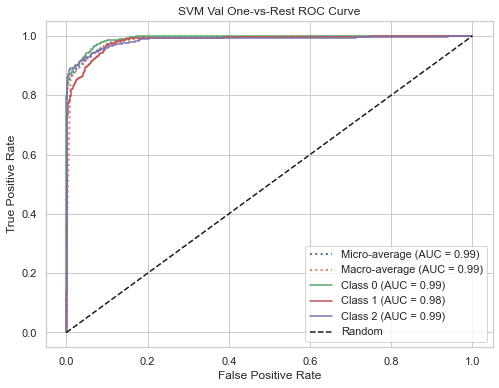

SVM Test Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       366
           1       0.84      0.93      0.88       303
           2       0.95      0.91      0.93       513

    accuracy                           0.91      1182
   macro avg       0.91      0.91      0.91      1182
weighted avg       0.91      0.91      0.91      1182

Test Confusion Matrix:
[[329  20  17]
 [ 13 281   9]
 [ 12  34 467]]
SVM Test Micro-average AUC = 0.99
SVM Test Macro-average AUC = 0.99
SVM Test Class 0 AUC = 0.99
SVM Test Class 1 AUC = 0.99
SVM Test Class 2 AUC = 0.99


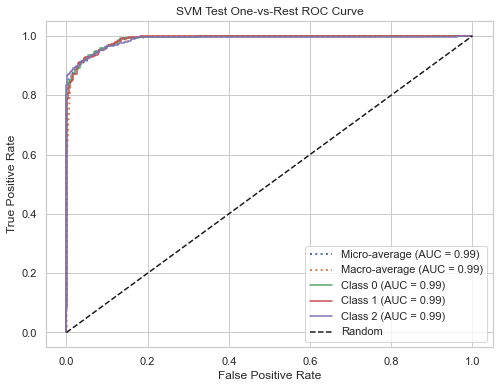

['SVM_classifier.pkl']

In [26]:
# Define the model
# model = SVC(C=10, probability=True, random_state=42, decision_function_shape='ovr', kernel='rbf')
model = SVC(C=10, probability=True, random_state=42, decision_function_shape='ovr', kernel='poly', gamma='scale',
            class_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]})

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("SVM Cross-Validation Scores:", cv_scores)
print(f"SVM Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"SVM Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"SVM Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"SVM Test Class {i} AUC = {roc_auc[i]:.2f}")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()

joblib.dump(clf, 'SVM_classifier.pkl')

In [ ]:
import shap

# We create the SHAP Explainer using the logistic regression model from the pipeline
# explainer = shap.Explainer(clf.named_steps['classifier'], clf.named_steps['preprocessor'].transform(X_train))

# We calculate SHAP values for the validation set (could be the training set or test set as well)
# shap_values = explainer(clf.named_steps['preprocessor'].transform(X_val))

# # Plotting the SHAP summary plot to show feature importances
# # Note that we're not explicitly passing feature names here.
# shap.summary_plot(shap_values, feature_names=clf.named_steps['preprocessor'].get_feature_names_out())
background_data = clf.named_steps['preprocessor'].transform(X_train.iloc[0:100])
explainer = shap.KernelExplainer(model=clf.named_steps['classifier'].predict_proba, data=background_data)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(clf.named_steps['preprocessor'].transform(X_test), nsamples='auto')

# Plotting the SHAP summary plot to show feature importances
# You may need to modify the way feature names are extracted if the method used here does not work with your version of scikit-learn
shap.summary_plot(shap_values, clf.named_steps['preprocessor'].transform(X_test), feature_names=all_feature_names)

  0%|          | 0/1183 [00:00<?, ?it/s]

In [ ]:
# from sklearn.model_selection import GridSearchCV
# # Define the parameter grid to search
# param_grid = {
#     'classifier__C': [0.1, 1, 10],
#     'classifier__kernel': ['linear', 'rbf', 'poly'],
#     'classifier__gamma': ['scale', 'auto']
# }

# grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)

# # Fit the model with the best hyperparameters on the entire training set
# clf = grid_search.best_estimator_




DecisionTreeClassifier

Decision Tree Cross-Validation Scores: [0.88432179 0.87844979 0.88901938 0.87191539 0.87250294]
Decision Tree Cross-Validated Accuracy: 0.88 +/- 0.01
Decision Tree Validation Accuracy: 0.88
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       623
           1       0.84      0.83      0.84       542
           2       0.91      0.92      0.91       964

    accuracy                           0.88      2129
   macro avg       0.88      0.87      0.88      2129
weighted avg       0.88      0.88      0.88      2129

Validation Confusion Matrix:
[[545  46  32]
 [ 34 451  57]
 [ 42  39 883]]


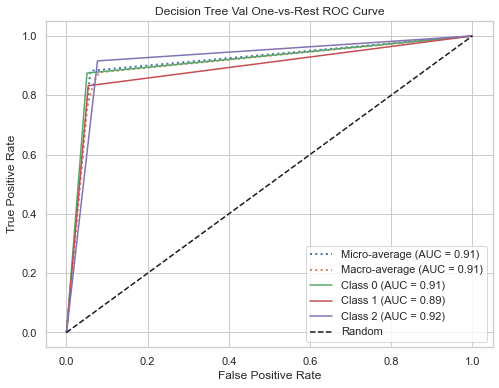

Decision Tree Test Accuracy: 0.88
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       366
           1       0.83      0.88      0.85       303
           2       0.91      0.91      0.91       513

    accuracy                           0.88      1182
   macro avg       0.88      0.88      0.88      1182
weighted avg       0.89      0.88      0.88      1182

Test Confusion Matrix:
[[313  28  25]
 [ 16 267  20]
 [ 20  28 465]]


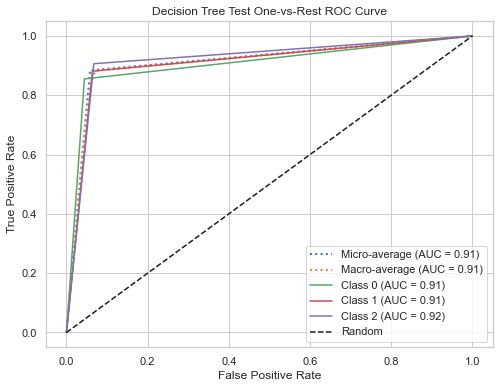

['DecisionTree_classifier.pkl']

In [29]:
# Define the model
model = DecisionTreeClassifier(random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Decision Tree Cross-Validation Scores:", cv_scores)
print(f"Decision Tree Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Decision Tree Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
# print(f"Decision Tree Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
# print(f"Decision Tree Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    # print(f"Decision Tree Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Decision Tree Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
# print(f"Decision Tree Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
# print(f"Decision Tree Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    # print(f"Decision Tree Test Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()

joblib.dump(clf, 'DecisionTree_classifier.pkl')

In [ ]:
import shap

# We create the SHAP Explainer using the logistic regression model from the pipeline
explainer = shap.Explainer(clf.named_steps['classifier'], clf.named_steps['preprocessor'].transform(X_train))

# We calculate SHAP values for the validation set (could be the training set or test set as well)
shap_values = explainer(clf.named_steps['preprocessor'].transform(X_val))

# Plotting the SHAP summary plot to show feature importances
shap.summary_plot(shap_values, clf.named_steps['preprocessor'].transform(X_val))

RandomForestClassifier

Random Forest Cross-Validation Scores: [0.90722255 0.90428655 0.91133294 0.88601645 0.88484136]
Random Forest Cross-Validated Accuracy: 0.90 +/- 0.01
Random Forest Validation Accuracy: 0.90
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       623
           1       0.86      0.87      0.86       542
           2       0.92      0.92      0.92       964

    accuracy                           0.90      2129
   macro avg       0.89      0.89      0.89      2129
weighted avg       0.90      0.90      0.90      2129

Validation Confusion Matrix:
[[559  28  36]
 [ 30 469  43]
 [ 32  47 885]]


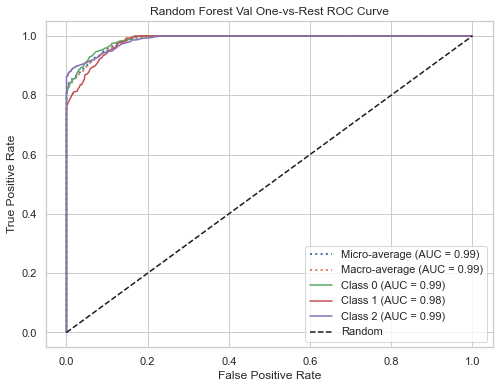

Random Forest Test Accuracy: 0.90
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       366
           1       0.82      0.87      0.85       303
           2       0.93      0.93      0.93       513

    accuracy                           0.90      1182
   macro avg       0.89      0.89      0.89      1182
weighted avg       0.90      0.90      0.90      1182

Test Confusion Matrix:
[[323  27  16]
 [ 19 263  21]
 [  9  29 475]]


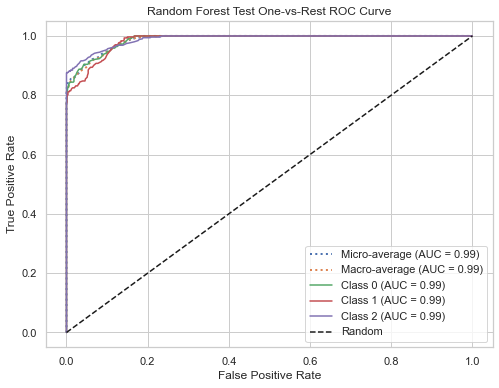

['RandomForest_classifier.pkl']

In [30]:
# Define the model
model = RandomForestClassifier(n_estimators=200, random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Random Forest Cross-Validation Scores:", cv_scores)
print(f"Random Forest Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Random Forest Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
# print(f"Decision Tree Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
# print(f"Decision Tree Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    # print(f"Random Forest Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Random Forest Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
# print(f"Decision Tree Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
# print(f"Decision Tree Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    # print(f"Random Forest Test Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()

joblib.dump(clf, 'RandomForest_classifier.pkl')

In [ ]:
import shap

# We create the SHAP Explainer using the logistic regression model from the pipeline
explainer = shap.Explainer(clf.named_steps['classifier'], clf.named_steps['preprocessor'].transform(X_train))

# We calculate SHAP values for the validation set (could be the training set or test set as well)
shap_values = explainer(clf.named_steps['preprocessor'].transform(X_val))

# Plotting the SHAP summary plot to show feature importances
shap.summary_plot(shap_values, clf.named_steps['preprocessor'].transform(X_val))